In [107]:
import json
from kafka import KafkaConsumer
from kafka import KafkaProducer
from elasticsearch import Elasticsearch
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
from sklearn.naive_bayes import GaussianNB

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [39]:
stopwords_set = set(stopwords.words('english'))
es = Elasticsearch()

In [40]:
def cleanup_tweet(text):
    tknzr = TweetTokenizer()
    
    text = text.lower()
    
    tokens = tknzr.tokenize(text)
    clean_tokens = []
    
    for token in tokens:
        # Skip hashtags
        if token[0] == "#":
            continue
            
        # Some words end with ":" or "!" are treated as non words. I'd like to include those actually.
        # An example is: "very happy!". Basically, it's a valid ngram, but sign at the end of word
        # results in it being treated as invalid word
        token = re.sub(r'[!:,]$', '', token)
        
        # Doesnt start with letter? Not a word, IMO
        if not re.match("^[a-zA-Z]+", token):
            continue
            
        # Link? Skip it!
        if re.match("^http[s]:\/\/", token):
            continue
            
        # Skip stopwords
        if token in stopwords_set:
            continue

        clean_tokens.append(token)
        
    return " ".join(clean_tokens)

In [41]:
text = 'Happy kid ❤\n#happy https://t.co/6F3SnnYA52'

cleanup_tweet(text)

'happy kid'

In [42]:
emotions_to_parse = ["happy", "sad"]

data = []

for emotion in emotions_to_parse:
    tweets = es.search(index="fetched_tweets", body={"query": {"match": { "full_text": "#" + emotion }}, "size": 10000})

    for msg in tweets['hits']['hits']:
        full_msg_text = None

        # Skip retweeted tweets
        if "retweeted_status" in msg['_source']:
            continue

        data.append({
            'tweet_id': msg['_id'],
            'full_text': msg['_source']['full_text'],
            'emotion': emotion
        })

In [43]:
data_df = pd.DataFrame(data)
data_df.set_index('tweet_id', inplace=True)
data_df['clean_text'] = data_df['full_text'].apply(cleanup_tweet)

In [44]:
data_df.head(5)

,emotion,full_text,clean_text
tweet_id,,,
1136544883064229888,happy,Happy kid ❤\n#happy https://t.co/6F3SnnYA52,happy kid
1136615042869338120,happy,Happy Thursday. #nycsubway #meandyou #happy h...,happy thursday
1136466744850038784,happy,"@maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑",looks comfy happy kev's dad
1136438986677923841,happy,Happy New Year 2018 Quotes: #Happy New Year 20...,happy new year quotes new year images new year...
1136599233392332801,happy,"Without you, I’m not happy\nbut I hope you’re ...",without happy hope happy watch far away withou...


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [46]:
# There were some duplicates ... remove them
deduplicated_df = data_df.loc[~data_df.index.duplicated(keep=False)]

In [47]:
tokens_list = []

for tweet_id, clean_text in deduplicated_df.clean_text.iteritems():
    for token in clean_text.split():
        
        tokens_list.append([
            tweet_id, 
            token, 
            data_df.loc[tweet_id].emotion,
            data_df.loc[tweet_id].clean_text,
            data_df.loc[tweet_id].full_text
        ])

tokens_df = pd.DataFrame(data=tokens_list, columns=['tweet_id', 'token', 'emotion', 'clean_text', 'full_text'])

In [48]:
total_word_counts = tokens_df.groupby('emotion').count()
total_word_counts

,tweet_id,token,clean_text,full_text
emotion,,,,
happy,8584,8584,8584,8584
sad,27756,27756,27756,27756


In [49]:
tokens_df['total_words'] = tokens_df['emotion'].apply(lambda x: total_word_counts.loc[x]['tweet_id'])

In [50]:
word_counts = tokens_df.groupby(['emotion', 'token'])['tweet_id'].count()
word_counts.head()

emotion  token             
happy    a1                    1
         aamazingpapercraft    1
         ability               2
         able                  3
         aboard                1
Name: tweet_id, dtype: int64

In [51]:
def get_occurences_of_word_in_emotion(word, emotion):
    try:
        cnt = word_counts.loc[emotion].loc[word]
    except:
        cnt = 0
    return cnt

In [52]:
get_occurences_of_word_in_emotion('ability', 'happy')

2

In [53]:
tokens_df['n'] = tokens_df.apply(lambda x: get_occurences_of_word_in_emotion(x['token'], x['emotion']), 1)

In [54]:
tokens_df.head()

,tweet_id,token,emotion,clean_text,full_text,total_words,n
0,1136544883064229888,happy,happy,happy kid,Happy kid ❤\n#happy https://t.co/6F3SnnYA52,8584,127
1,1136544883064229888,kid,happy,happy kid,Happy kid ❤\n#happy https://t.co/6F3SnnYA52,8584,2
2,1136615042869338120,happy,happy,happy thursday,Happy Thursday. #nycsubway #meandyou #happy h...,8584,127
3,1136615042869338120,thursday,happy,happy thursday,Happy Thursday. #nycsubway #meandyou #happy h...,8584,26
4,1136466744850038784,looks,happy,looks comfy happy kev's dad,"@maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑",8584,6


In [55]:
tokens_df[['emotion', 'token', 'n', 'total_words']].head(20)

,emotion,token,n,total_words
0,happy,happy,127,8584
1,happy,kid,2,8584
2,happy,happy,127,8584
3,happy,thursday,26,8584
4,happy,looks,6,8584
5,happy,comfy,1,8584
6,happy,happy,127,8584
7,happy,kev's,1,8584
8,happy,dad,3,8584
9,happy,happy,127,8584


In [56]:
tokens_df['term_frequency'] = tokens_df['n'] / tokens_df['total_words']

In [57]:
tokens_df[['emotion', 'token', 'n', 'total_words', 'term_frequency']].head(20)

,emotion,token,n,total_words,term_frequency
0,happy,happy,127,8584,0.014795
1,happy,kid,2,8584,0.000233
2,happy,happy,127,8584,0.014795
3,happy,thursday,26,8584,0.003029
4,happy,looks,6,8584,0.000699
5,happy,comfy,1,8584,0.000116
6,happy,happy,127,8584,0.014795
7,happy,kev's,1,8584,0.000116
8,happy,dad,3,8584,0.000349
9,happy,happy,127,8584,0.014795


In [58]:
tokens_df.drop_duplicates('token', inplace=True)

In [59]:
tokens_df[['emotion', 'token', 'n', 'total_words', 'term_frequency']].head(20)

,emotion,token,n,total_words,term_frequency
0,happy,happy,127,8584,0.014795
1,happy,kid,2,8584,0.000233
3,happy,thursday,26,8584,0.003029
4,happy,looks,6,8584,0.000699
5,happy,comfy,1,8584,0.000116
7,happy,kev's,1,8584,0.000116
8,happy,dad,3,8584,0.000349
10,happy,new,44,8584,0.005126
11,happy,year,22,8584,0.002563
12,happy,quotes,2,8584,0.000233


In [60]:
import math

In [61]:
def get_idf_for_word(word):
    N = 2 # We are working with two emotions, so ...
    
    occurences = tokens_df[tokens_df['token'] == word]['token'].count()
    
    return math.log10(N / occurences)
    

In [62]:
get_idf_for_word('year')

0.3010299956639812

In [63]:
tokens_df['idf'] = tokens_df['token'].apply(lambda x: get_idf_for_word(x))

In [64]:
tokens_df.head(10)

,tweet_id,token,emotion,clean_text,full_text,total_words,n,term_frequency,idf
0,1136544883064229888,happy,happy,happy kid,Happy kid ❤\n#happy https://t.co/6F3SnnYA52,8584,127,0.014795,0.30103
1,1136544883064229888,kid,happy,happy kid,Happy kid ❤\n#happy https://t.co/6F3SnnYA52,8584,2,0.000233,0.30103
3,1136615042869338120,thursday,happy,happy thursday,Happy Thursday. #nycsubway #meandyou #happy h...,8584,26,0.003029,0.30103
4,1136466744850038784,looks,happy,looks comfy happy kev's dad,"@maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑",8584,6,0.000699,0.30103
5,1136466744850038784,comfy,happy,looks comfy happy kev's dad,"@maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑",8584,1,0.000116,0.30103
7,1136466744850038784,kev's,happy,looks comfy happy kev's dad,"@maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑",8584,1,0.000116,0.30103
8,1136466744850038784,dad,happy,looks comfy happy kev's dad,"@maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑",8584,3,0.000349,0.30103
10,1136438986677923841,new,happy,happy new year quotes new year images new year...,Happy New Year 2018 Quotes: #Happy New Year 20...,8584,44,0.005126,0.30103
11,1136438986677923841,year,happy,happy new year quotes new year images new year...,Happy New Year 2018 Quotes: #Happy New Year 20...,8584,22,0.002563,0.30103
12,1136438986677923841,quotes,happy,happy new year quotes new year images new year...,Happy New Year 2018 Quotes: #Happy New Year 20...,8584,2,0.000233,0.30103


In [65]:
tokens_df['tf_idf'] = tokens_df['term_frequency'] * tokens_df['idf']

In [66]:
tokens_df[tokens_df['emotion'] == 'happy'][['token', 'term_frequency', 'idf', 'tf_idf']].sort_values(by='tf_idf', ascending=False).head(10)

,token,term_frequency,idf,tf_idf
0,happy,0.014795,0.30103,0.004454
82,day,0.009902,0.30103,0.002981
38,life,0.008737,0.30103,0.002630
305,love,0.008737,0.30103,0.002630
131,make,0.007689,0.30103,0.002315
101,good,0.006524,0.30103,0.001964
955,like,0.005941,0.30103,0.001789
451,today,0.005592,0.30103,0.001683
161,time,0.005475,0.30103,0.001648
632,us,0.005359,0.30103,0.001613


In [67]:
tokens_df[tokens_df['emotion'] == 'sad'][['token', 'term_frequency', 'idf', 'tf_idf']].sort_values(by='tf_idf', ascending=False).head(30)

,token,term_frequency,idf,tf_idf
9422,trump,0.006269,0.30103,0.001887
9021,president,0.003783,0.30103,0.001139
8584,sad,0.003207,0.30103,0.000965
9568,uk,0.001405,0.30103,0.000423
10142,fake,0.001261,0.30103,0.000380
8729,america,0.001261,0.30103,0.000380
12879,stories,0.001045,0.30103,0.000315
9601,realdonaldtrump,0.000937,0.30103,0.000282
8760,low,0.000937,0.30103,0.000282
9373,obama,0.000901,0.30103,0.000271


In [69]:
word_features_to_take = ['happy', 'day', 'life', 'love', 'make', 'trump', 'president', 'sad', 'uk', 'fake']

In [82]:
def vectorize_tweet(raw_tweet):
    clean_tweet = cleanup_tweet(raw_tweet)
    
    vector = {word: 0 for word in word_features_to_take}
    
    for token in clean_tweet.split():
        if token not in vector:
            continue
            
        vector[token] += 1
        
    return vector

In [91]:
X = deduplicated_df.full_text.values
y = deduplicated_df.emotion.values

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [93]:
X_train.shape

(3071,)

In [94]:
X_test.shape

(1024,)

In [95]:
y_train.shape

(3071,)

In [99]:
# There's a clear disbalance between happy and sad ...
pd.Series(data=y_train).value_counts()

sad      2168
happy     903
dtype: int64

In [114]:
train_vectors = [vectorize_tweet(tweet) for tweet in X_train]
test_vectors = [vectorize_tweet(tweet) for tweet in X_test]

In [116]:
train_df = pd.DataFrame(data=train_vectors, columns=word_features_to_take)
test_df = pd.DataFrame(data=test_vectors, columns=word_features_to_take)

In [123]:
train_df.head(5)

,happy,day,life,love,make,trump,president,sad,uk,fake
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0


In [117]:
model = GaussianNB()
model.fit(train_df, y_train)

GaussianNB(priors=None)

In [118]:
# Accuracy on train data?
y_train_predicted = model.predict(train_df)

In [119]:
accuracy_score(y_train, y_train_predicted)

0.38489091501139694

In [120]:
y_pred = model.predict(test_df)
accuracy_score(y_test, y_pred)

0.42578125

In [139]:
from sklearn.naive_bayes import MultinomialNB

In [140]:
model = MultinomialNB()
model.fit(train_df, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [141]:
y_train_predicted = model.predict(train_df)
accuracy_score(y_train, y_train_predicted)

0.737544773689352

In [142]:
y_pred = model.predict(test_df)
accuracy_score(y_test, y_pred)

0.689453125

In [156]:
happy_emotion_token_data = tokens_df[tokens_df['emotion'] == 'happy'][['token', 'term_frequency', 'idf', 'tf_idf']].sort_values(by='tf_idf', ascending=False)
happy_emotion_token_data.head(5)

,token,term_frequency,idf,tf_idf
0,happy,0.014795,0.30103,0.004454
82,day,0.009902,0.30103,0.002981
38,life,0.008737,0.30103,0.002630
305,love,0.008737,0.30103,0.002630
131,make,0.007689,0.30103,0.002315


In [157]:
sad_emotion_token_data = tokens_df[tokens_df['emotion'] == 'sad'][['token', 'term_frequency', 'idf', 'tf_idf']].sort_values(by='tf_idf', ascending=False)
sad_emotion_token_data.head(5)

,token,term_frequency,idf,tf_idf
9422,trump,0.006269,0.30103,0.001887
9021,president,0.003783,0.30103,0.001139
8584,sad,0.003207,0.30103,0.000965
9568,uk,0.001405,0.30103,0.000423
10142,fake,0.001261,0.30103,0.000380


In [136]:
def get_feature_tokens(num_features):
    """Returns number of feature words times 2
    
    e.g. if you pass "3" as num_features, it will return top 3 tokens
    from "happy" dataset and top 3 from "sad" dataset, producing total
    of 6 features.
    """
    
    return np.append(happy_emotion_token_data.token.head(num_features).values, sad_emotion_token_data.token.head(num_features).values)

In [138]:
get_feature_tokens(3)

array(['happy', 'day', 'life', 'trump', 'president', 'sad'], dtype=object)

In [143]:
from sklearn.ensemble import RandomForestClassifier

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [145]:
model = RandomForestClassifier(n_estimators=100)
model.fit(train_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [146]:
y_train_predicted = model.predict(train_df)
accuracy_score(y_train, y_train_predicted)

0.7404754151742103

In [147]:
y_pred = model.predict(test_df)
accuracy_score(y_test, y_pred)

0.6884765625

In [161]:
def vectorize_tweet_using_feature_array(raw_tweet, features_array):
    clean_tweet = cleanup_tweet(raw_tweet)
    
    vector = {word: 0 for word in features_array}
    
    for token in clean_tweet.split():
        if token not in vector:
            continue
            
        vector[token] += 1
        
    return vector

In [206]:
# Let's see how increasing number of features affects the outcome

scores = []

for num_features in range(2, 500):
    feature_tokens = get_feature_tokens(num_features) # Get features (tokens) to use as vectors
    
    train_vectors = [vectorize_tweet_using_feature_array(tweet, feature_tokens) for tweet in X_train]
    test_vectors = [vectorize_tweet_using_feature_array(tweet, feature_tokens) for tweet in X_test]
    
    train_df = pd.DataFrame(data=train_vectors, columns=feature_tokens)
    test_df = pd.DataFrame(data=test_vectors, columns=feature_tokens)
    
    model = MultinomialNB()
    model.fit(train_df, y_train)
    
    y_train_predicted = model.predict(train_df)
    y_pred = model.predict(test_df)
    
    accuracy_score_train_data = accuracy_score(y_train, y_train_predicted)
    accuracy_score_test_data = accuracy_score(y_test, y_pred)
    
    print(num_features)
    scores.append([num_features, accuracy_score_train_data, accuracy_score_test_data])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [212]:
np.where(scores_nparray[:, 2] == max(scores_nparray[:, 2]))

(array([487]),)

In [214]:
scores_nparray[487]

array([489.        ,   0.8580267 ,   0.80566406])

In [211]:
scores_nparray

array([[  2.        ,   0.73721915,   0.68847656],
       [  3.        ,   0.73721915,   0.6875    ],
       [  4.        ,   0.73721915,   0.68847656],
       ...,
       [497.        ,   0.85965484,   0.80371094],
       [498.        ,   0.86030609,   0.8046875 ],
       [499.        ,   0.86095734,   0.8046875 ]])

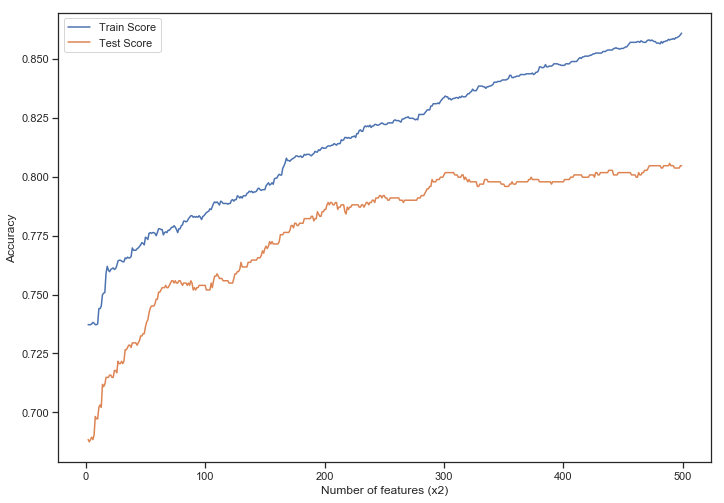

In [208]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
plt.plot(scores_nparray[:, 0], scores_nparray[:, 1], label="Train Score")
plt.plot(scores_nparray[:, 0], scores_nparray[:, 2], label="Test Score")
plt.xlabel('Number of features (x2)')
plt.ylabel('Accuracy');
ax.legend()

In [209]:
# Let's try Stemming the words

In [210]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

In [215]:
import pickle

output = open('regular_scores.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(scores_nparray, output)

output.close()